In [1]:
import pandas as pd
pd.__version__

'0.23.4'

In [43]:
%matplotlib inline
from sklearn import datasets, linear_model
import numpy as np
import matplotlib.pyplot as plt
# Set plot font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.size'] = 16
use_pickle = True
power_y_lim = .25

In [4]:
 import sys
 print(sys.executable)
 print(sys.version)
 print(sys.version_info)

/Users/arafferty/anaconda/bin/python
3.5.2 |Anaconda custom (x86_64)| (default, Jul  2 2016, 17:52:12) 
[GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]
sys.version_info(major=3, minor=5, micro=2, releaselevel='final', serial=0)


### String Constants

In [5]:
df_suffix = 'Df.pkl'
byTrial_suffix = 'DfByTrial.pkl'
overall_suffix = 'OverallStatsDf.pkl'
summary_suffix = 'SummaryText.txt'
date_prefix = '180123'
date_prefix_normal = '180427'

outdir_prefix = 'graphs/'
outdir_prefix_std_error = 'graphsWithStandardErrorBars/'

BINARY = "B"
NORMAL = "N"

BANDIT = "Bandit Sampling"
PRIOR_BTW = "Prior between"
PRIOR_BELOW = "Prior below"
PRIOR_ABOVE = "Prior above"
UNIFORM = "Uniform Sampling"
mean_names_lst = (PRIOR_BTW, PRIOR_BELOW, PRIOR_ABOVE, UNIFORM)
std_names_lst = (PRIOR_BTW + " std", PRIOR_BELOW + " std", PRIOR_ABOVE + " std", UNIFORM + " std")

bb_prefix = "bbEqualMeansEqualPrior"
bb_infix = "BB0N"
bu_prefix = "bbEqualMeansUniform"
bu_infix = "BU0N"
bb_prior_below_prefix = "bbEqualMeansArmsHigh"
bb_prior_above_prefix = "bbEqualMeansArmsLow"
b_prefix_lst = [bb_prefix, bb_prior_below_prefix, bb_prior_above_prefix, bu_prefix]
b_infix_lst = [bb_infix, bb_infix, bb_infix, bu_infix]

ng_prefix = "ngEqualMeansEqualPrior"
ng_infix = "NG0N"
nu_prefix = "ngEqualMeansUniform"
nu_infix = "NU0N"
ng_var = "Var"
ng_prior_below_prefix = "ngEqualMeansArmsHigh"
ng_prior_above_prefix = "ngEqualMeansArmsLow"
n_prefix_lst = (ng_prefix, ng_prior_below_prefix, ng_prior_above_prefix, nu_prefix)
n_infix_lst = (ng_infix, ng_infix, ng_infix, nu_infix)

# (Optimal, Prior Btw, Prior below, Prior above, Uniform)
colors = ('#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99')
# (Optimal, Prior Btw, Prior Btw Regression, Uniform, Uniform Regression)
colors_line = ('#a6cee3','#1f78b4','#fc8d62','#fb9a99','#018571')

### Simulation Settings

In [6]:
variancesT = {'394':'5.0', '64':'2.0', '26':'1.25'}
variance_label = ("Small", "Moderate", "Large")
nsT = (394, 64, 26)
nsB = (785, 88, 32)

In [7]:
# Acutal rewards
ng_prior_btw = (0.0, 0.0)
ng_prior_below = (0.5, 0.5)
ng_prior_above = (-0.5, -0.5)
ng_uniform = (0.0, 0.0)
ng_reward_dict = {PRIOR_BTW:ng_prior_btw, PRIOR_BELOW:ng_prior_below, PRIOR_ABOVE:ng_prior_above, UNIFORM:ng_uniform}

# Average Reward Gain per Step

In [8]:
def scale_normal_rewards(x, arm):
    return (x + (0.5 - arm))

In [9]:
def get_avg_col_per_num_steps_dfs(ns, reward_type, col, stdError=False):
    df_lst = []
    ns = str(ns)
    if reward_type == BINARY:
        prefix_lst = b_prefix_lst
        infix_lst = b_infix_lst
    elif reward_type == NORMAL:
        prefix_lst = n_prefix_lst
        infix_lst = n_infix_lst
    
    for i in range(len(prefix_lst)):
        prefix = prefix_lst[i]
        infix = infix_lst[i]
        if reward_type == BINARY:
            df = pd.read_pickle(prefix+ns+infix+ns+df_suffix)
        else:
            df = pd.read_pickle(prefix+variancesT[ns]+infix+ns+"Var"+variancesT[ns]+df_suffix)
        df_lst.append(df)
        
    avg_lst = []
    std_lst = []
    for i in range(len(df_lst)):
        df = df_lst[i]
        
        gp = df[['num_steps', col]].groupby('num_steps')
        
        avg = gp.mean().reset_index().rename(columns={col: mean_names_lst[i]})
        avg_lst.append(avg)
        std = gp.std().reset_index().rename(columns={col: std_names_lst[i]})
        if (stdError):
            count = gp.size().reset_index(name='counts')
            std[std_names_lst[i]] = std[std_names_lst[i]] / np.sqrt(count['counts'])
        
        std_lst.append(std)

    result = pd.merge(avg_lst[0], avg_lst[1], how='outer', on=['num_steps'])
    for i in range(2, len(avg_lst)):
        result = pd.merge(result, avg_lst[i], how='outer', on=['num_steps'])
    for i in range(len(std_lst)):
        result = pd.merge(result, std_lst[i], how='outer', on=['num_steps'])
        
    result = result.reset_index(drop=True).set_index('num_steps')

    return result

In [10]:
def get_avg_col_per_step_dfs(ns, reward_type, col, stdError=False):
    avg_total_rewards = get_avg_col_per_num_steps_dfs(ns, reward_type, col, stdError)
    for column in avg_total_rewards.columns:
        # Update mean and std
        avg_total_rewards[column] = avg_total_rewards[column] / avg_total_rewards.index

        # Apply scaling if normal rewards
        if col == "total_reward" and reward_type == NORMAL:
            if "std" not in column:
                # scale avg                
                avg_total_rewards[column] = avg_total_rewards[column].\
                apply(scale_normal_rewards, args=(ng_reward_dict[column][0],))
    return avg_total_rewards

### Get Better arm (2 arms)

In [11]:
import ast
def get_better_arm(ns, reward_type):
    ns = str(ns)
    if reward_type == BINARY:
        summary = open(bb_prefix+ns+bb_infix+ns+summary_suffix)
    elif reward_type == NORMAL:
        return 0.5

    for line in summary:
        if line.startswith("Arm stats:"):
            arms = line.split(':')[1].strip()
            return max(ast.literal_eval(arms)[:2])

## Line Plot

In [12]:
def subplot_line(df, ns, rewards_type, ax, setLegend, title, legend_anchor=(0.5, 1.95),\
                ylabel="", hline_value=None, hline_label=None, setLinearRegression=True, color=None):
    
    legend = []
    
    i = 0
    if hline_value!=None:
        if color == None:
            ax.axhline(hline_value, linestyle='dashed', linewidth=2)
        else:
            ax.axhline(hline_value, linestyle='dashed', linewidth=2, color=color[i])
            i += 1
        legend.append(hline_label)

    for col in df.columns.values:       
        x = df.index.values.reshape(len(df.index.values), 1)
        y = df[col].values
        
        if color == None:
            plt.plot(x, y)
        else:
            plt.plot(x, y, color=color[i])
            i+=1
       
        legend.append(col)
        if setLinearRegression:
            regr = linear_model.LinearRegression()
            regr.fit(x, y)
            
            if color == None:
                plt.plot(x, regr.predict(x), linewidth=2)
            else:
                plt.plot(x, regr.predict(x), linewidth=2, color=color[i])
                i += 1

            legend.append(col+" Regression")
    plt.xlabel("Step")
    ax.set_ylabel(ylabel)

    plt.title(title)

    if setLegend:
        ax.legend(legend, ncol=len(legend), bbox_to_anchor=legend_anchor)

# Average Reward Gain at each Step

In [13]:
def get_avg_col_per_trial_dfsByTrial(ns, reward_type, col, includeBelowAbove):
    df_lst = []
    ns = str(ns)
    if reward_type == BINARY:
        prefix_lst = b_prefix_lst
        infix_lst = b_infix_lst
    elif reward_type == NORMAL:
        prefix_lst = n_prefix_lst
        infix_lst = n_infix_lst
    
    columns = list(mean_names_lst)
    if not includeBelowAbove:
        prefix_lst = [prefix_lst[0], prefix_lst[-1]]
        infix_lst = [infix_lst[0], infix_lst[-1]]
        columns = [columns[0], columns[-1]]
    
    for i in range(len(prefix_lst)):
        prefix = prefix_lst[i]
        infix = infix_lst[i]
        if reward_type == BINARY:
            df = pd.read_pickle(prefix+ns+infix+ns+byTrial_suffix)
        else:
            df = pd.read_pickle(prefix+variancesT[ns]+infix+ns+"Var"+variancesT[ns]+byTrial_suffix)
        df_lst.append(df)
        
    avg_lst = []
    std_lst = []
    for i in range(len(df_lst)):
        df = df_lst[i]
        
        gp = df[['trial', col]].groupby('trial')
        
        avg = gp.mean().reset_index().rename(columns={col: columns[i]})

        for j in range(len(avg['trial'])-1):
            avg.loc[j,columns[i]] = avg.loc[j+1,columns[i]] - avg.loc[j,columns[i]]
            
        if col == "total_reward" and reward_type == NORMAL:
            avg[columns[i]] = avg[columns[i]].\
            apply(scale_normal_rewards, \
                  args=(ng_reward_dict[columns[i]][0],))

        avg_lst.append(avg)

    result = pd.merge(avg_lst[0], avg_lst[1], how='outer', on=['trial'])
    for i in range(2, len(avg_lst)):
        result = pd.merge(result, avg_lst[i], how='outer', on=['trial'])
   
    result = result.reset_index(drop=True).set_index('trial')
    
    return result.iloc[:-1]

In [14]:
def plot_avg_reward_gain_at_m(reward_type, legend_anchor=(0.3, 1.5), stdError=False):
    df = pd.DataFrame(dtype=float)
    if reward_type == BINARY:
        nsL = nsB
    elif reward_type == NORMAL:
        nsL = nsT
    for i in range(len(nsL)):
        ns = nsL[i]
        df_m = get_avg_col_per_step_dfs(ns, reward_type, "total_reward", stdError).iloc[1:2]
        df_m["ns"] = ns
        df_m["Optimal Reward"] = get_better_arm(nsL[i], reward_type)
        df_m["or_std"] = pd.Series()

        df = pd.concat([df, df_m])
    df = df.reset_index().set_index('ns')
    m = df[["Optimal Reward"]+list(mean_names_lst)]
    std = df[list(std_names_lst)+['or_std']]
    std.columns = list(mean_names_lst)+['Optimal Reward']
    ax = m.plot.bar(yerr=std, rot=0, color=colors)

    ax.set_xlabel('')
    xticks = []
    for i in range(len(df.index.values)):
        xticks.append("num_steps="+str(df['num_steps'].values[i]))
    ax.set_xticklabels(xticks)
    ax.set_ylabel("Reward")
    
    ax.legend(ncol=5, bbox_to_anchor=legend_anchor)

    if reward_type == BINARY:
        ax.set_title("Average Reward Gain per Step in m Steps (Binary Reward)")
    elif reward_type == NORMAL:
        ax.set_title("Average Reward Gain per Step in m Steps (Scaled, Normal Reward)")
    return ax

### Binary Rewards

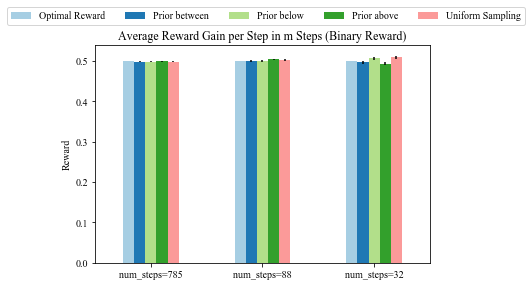

In [30]:
ax = plot_avg_reward_gain_at_m(BINARY, legend_anchor=(1.3, 1.2), stdError=True)

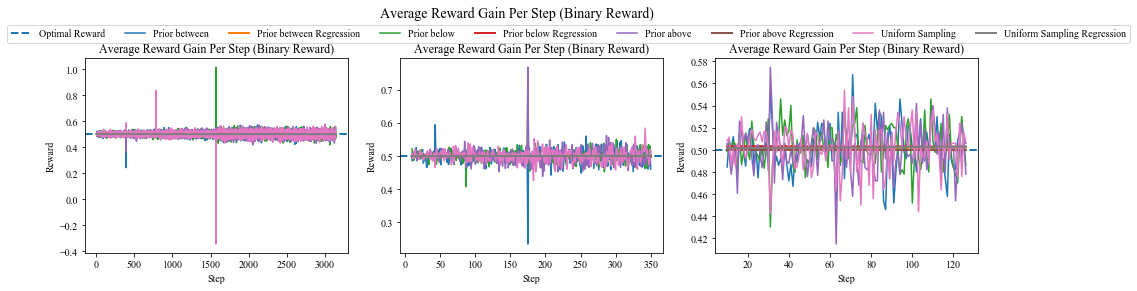

In [14]:
figure = plt.figure(figsize = (16, 4))
setLegend = True

# Plot subgraphs
axes = []
for i in range(len(nsB)):
    ax = figure.add_subplot(1, len(nsB), i + 1)
    axes.append(ax)

    avg_rewards_per_trial_binary = get_avg_col_per_trial_dfsByTrial(nsB[i], BINARY, "total_reward", True)
    subplot_line(avg_rewards_per_trial_binary, nsB[i], "Binary", ax, setLegend, "Average Reward Gain Per Step (Binary Reward)", \
                ylabel="Reward", legend_anchor=(4, 1.2), hline_value=get_better_arm(nsB[i], BINARY), hline_label="Optimal Reward")
    setLegend = False

# Set super title for all subgraphs
figure.suptitle("Average Reward Gain Per Step (Binary Reward)",  fontsize=14)
plt.subplots_adjust(top=0.8)

### Normal Rewards

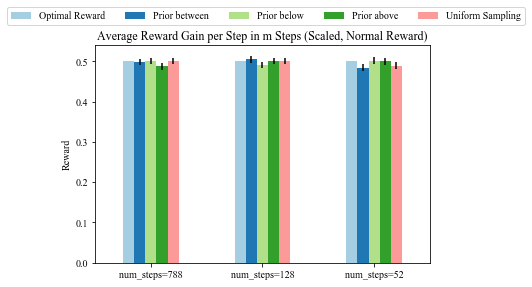

In [31]:
ax = plot_avg_reward_gain_at_m(NORMAL, legend_anchor=(1.3, 1.2), stdError=True)

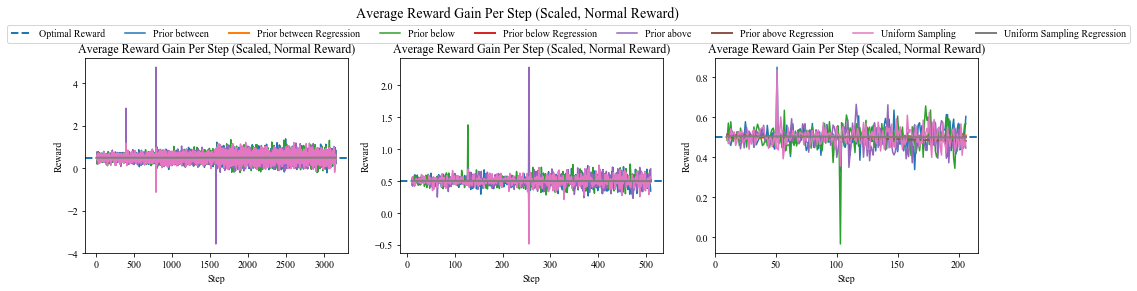

In [16]:
figure = plt.figure(figsize = (16, 4))
setLegend = True

# Plot subgraphs
axes = []
for i in range(len(nsT)):
    ax = figure.add_subplot(1, len(nsT), i + 1)
    axes.append(ax)

    avg_rewards_per_trial_normal = get_avg_col_per_trial_dfsByTrial(nsT[i], NORMAL, "total_reward", True)
    subplot_line(avg_rewards_per_trial_normal, nsT[i], "Normal", ax, setLegend, "Average Reward Gain Per Step (Scaled, Normal Reward)", \
                ylabel="Reward", legend_anchor=(4, 1.2), hline_value=get_better_arm(nsT[i], NORMAL), hline_label="Optimal Reward")
    setLegend = False

# Set super title for all subgraphs
figure.suptitle("Average Reward Gain Per Step (Scaled, Normal Reward)",  fontsize=14)
plt.subplots_adjust(top=0.8)

# Type I Error

In [16]:
def get_power_by_steps(dfs_by_trial, columns, alpha = 0.05):
    '''
    df_by_trial is a data frame with information about each run,
    as calculated by calculate_by_trial_statistics_from_sims.
    This function returns the continuous evaluation of power at every step until 4m steps,
    and the power snapshot at step 0.5m, m, 2m and 4m for all effect sizes.
    Power is calculated as what proportion of the p-values were below alpha at that point.
    '''
    unique_sample_sizes = dfs_by_trial[0].num_steps.unique()
    power_df = pd.DataFrame(columns=columns)
    power_all_steps = []
    for i in range(len(unique_sample_sizes)):
        cur_n = unique_sample_sizes[i]
        power_df.loc[i,columns[0]] = cur_n
        # Add bandit and uniform sampling lines 
        j = 1
        for df in dfs_by_trial:
            cur_df = df[df['num_steps'] == cur_n]
            statistic_list = []
            for trial in range(10, cur_n):
                avg_stat = np.sum(cur_df[cur_df['trial'] == trial]['pvalue'] < alpha) \
                            / len(cur_df[cur_df['trial'] == trial])
                statistic_list.append(avg_stat)
            
            if cur_n == unique_sample_sizes[-1]:
                power_all_steps.append(statistic_list[:])
            
            power_df.iloc[i, j] = statistic_list[-1]
            j+=1
    return power_all_steps, power_df

In [17]:
def plot_power_bar(df, x_col, y_col, effect_size, ax, setLegend, title, legend_anchor=(0.5, 1.7), ylabel="", \
                   hline_value=None, hline_label=None, color=colors):
    x = df[x_col]
    y = df[y_col]

    y.plot.bar(ax=ax, rot=0, color=color[1:])
    plt.xlabel("Sample size, m="+str(x.iloc[1, 0]))
    ax.set_xticklabels(['0.5m', 'm', '2m', '4m'])
    # set visualization range to 0-1
    ax.set_ylim(0.0, power_y_lim)
    
    legend = y_col
    
    if hline_value!=None:
        ax.axhline(hline_value, color=color[0], linestyle='dashed', linewidth=2)
        legend.insert(0, hline_label)

    plt.title(title)
    
    if setLegend:
        leg = ax.legend(legend, ncol=len(legend), bbox_to_anchor=legend_anchor)
        leg.get_texts()[len(leg.get_texts()) - 1].set_text('Uniform assignment')

        ax.set_ylabel(ylabel)
    else:
        ax.legend_.remove()

### Binary Reward

In [19]:
if not use_pickle:
    binary_power = []
    ns = str(nsB[0])
    df_lst = []
    prefix_lst = b_prefix_lst
    infix_lst = b_infix_lst
    for i in range(len(prefix_lst)):
        prefix = prefix_lst[i]
        infix = infix_lst[i]
        df = pd.read_pickle(prefix+ns+infix+ns+byTrial_suffix)
        df_lst.append(df)

    power_all_steps, power_df = get_power_by_steps(df_lst, ["num_steps"] + list(mean_names_lst))
    binary_power = power_all_steps
    import pickle
    with open(date_prefix+'BinaryPowerSameArms.pkl', 'wb') as f:
        pickle.dump(binary_power, f)

In [20]:
# figure = plt.figure(figsize = (20, 5))
# setLegend = True
# # # Bar graph for power at step m
# # for i in range(len(nsB)):
# #     ax = figure.add_subplot(1, len(nsB) + 1, i + 1)

# #     avg_power_binary = binary_power[i]
# #     plot_power_bar(avg_power_binary, ["num_steps"], list(mean_names_lst), nsB[i], ax, setLegend, \
# #                    "Power At Step \n("+variance_label[i]+" Variance)",\
# #                    legend_anchor=(0.6, 1.65), ylabel="Power", hline_value=0.0, hline_label="Expected Power")
# #     setLegend = False
    
# # Line graph for power per step for mid effect size
# ax = figure.add_subplot(1, 1, 1)
# ax.axhline(0.0, color=colors[0], linestyle='dashed', linewidth=2)
# i = 1
# for p in binary_power:
#     x = range(10, len(p)+10)
#     ax.plot(x, p, lw=2, color=colors[i])
#     i+=1
# ax.set_xlabel('Step')
# ax.legend(["Expected Power"]+list(mean_names_lst), bbox_to_anchor=(0.6, 1.65))
# plt.title("Changing Power Over Time \n (Binary Reward)")

# figure.suptitle("Type I Error By Step",  fontsize=14)
# plt.subplots_adjust(top=0.75)
# figure.savefig(outdir_prefix+date_prefix+'MeasuredPowerPerStepBinary.pdf', bbox_inches='tight')

### Normal Reward

In [21]:
if not use_pickle:
    normal_power = []
    normal_power_mid_var = []
    for i in range(len(nsT)):
        ns = str(nsT[i])
        df_lst = []
        prefix_lst = n_prefix_lst
        infix_lst = n_infix_lst
        for i in range(len(prefix_lst)):
            prefix = prefix_lst[i]
            infix = infix_lst[i]
            df = pd.read_pickle(prefix+variancesT[ns]+infix+ns+"Var"+variancesT[ns]+byTrial_suffix)
            df_lst.append(df)

        power_all_steps, power_df = get_power_by_steps(df_lst, ["num_steps"]+list(mean_names_lst))
        normal_power.append(power_df)
        if ns == str(nsT[len(nsT) // 2]):
            normal_power_mid_var = power_all_steps

    import pickle
    with open(date_prefix+'NormalPowerSameArms.pkl', 'wb') as f:
        pickle.dump(normal_power, f)

    with open(date_prefix+'NormalPowerMidVarSameArms.pkl', 'wb') as f:
        pickle.dump(normal_power_mid_var, f) 

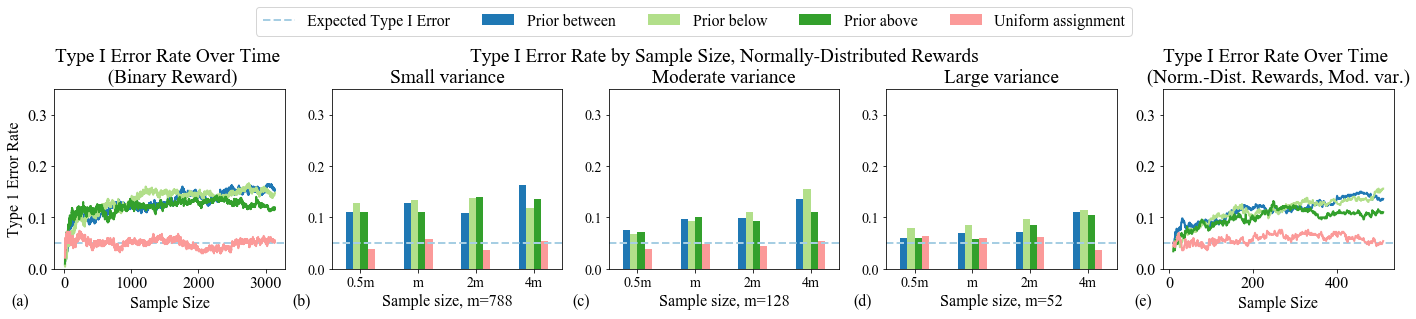

In [10]:
if use_pickle:
    import pickle
    binary_power = pd.read_pickle(date_prefix+'BinaryPowerSameArms.pkl')
    normal_power = pd.read_pickle(date_prefix_normal+'NormalPowerSameArms.pkl')
    normal_power_mid_var = pd.read_pickle(date_prefix_normal+'NormalPowerMidVarSameArms.pkl')
# Draw single graph for both binary and normal reward regarding type I error
figure = plt.figure(figsize = (24, 4))
setLegend = True

# Line graph for Type I Error per step for Binary Reward
ax = figure.add_subplot(1, len(nsT) + 2, 1)
ax.axhline(0.05, color=colors[0], linestyle='dashed', linewidth=2)
i = 1
for p in binary_power:
    x = range(10, len(p)+10)
    ax.plot(x, p, lw=2, color=colors[i])
    i+=1
ax.set_xlabel('Sample Size')
ax.set_ylabel('Type 1 Error Rate')

# set visualization range to 0-1
ax.set_ylim(0.0, power_y_lim)
ax.tick_params(axis='both', which='major')
plt.title("Type I Error Rate Over Time \n (Binary Reward)")

# Subgraphs for Type I Error per step for Normal Reward
setLegend = True
# Bar graph for power at step m
for i in range(len(nsT)):
    ax = figure.add_subplot(1, len(nsT) + 2, i + 2)

    avg_power_normal = normal_power[i]
    title_text = variance_label[i]+" variance"
    if i == len(nsT) // 2:
        title_text = "Type I Error Rate by Sample Size, Normally-Distributed Rewards\n"+ title_text
    plot_power_bar(avg_power_normal, ["num_steps"], list(mean_names_lst), nsT[i], ax, setLegend, \
                   title_text, \
                   legend_anchor=(3.5, 1.5), ylabel="", hline_value=0.05, hline_label="Expected Type I Error")
    ax.tick_params(axis='both', which='major', labelsize=14)
    setLegend = False
    
# Line graph for power per step for mid effect size
ax = figure.add_subplot(1, len(nsT) + 2, len(nsT) + 2)
ax.axhline(0.05, color=colors[0], linestyle='dashed', linewidth=2)
i = 1
for p in normal_power_mid_var:
    x = range(10, len(p)+10)
    ax.plot(x, p, lw=2, color=colors[i])
    i+=1
ax.set_xlabel('Sample Size')
# set visualization range to 0-1
ax.set_ylim(0.0, power_y_lim)
ax.tick_params(axis='both', which='major')
plt.title("Type I Error Rate Over Time \n(Norm.-Dist. Rewards, Mod. var.)")
starting_label_x = 0.1
label_y = 0
label_x_increment = 0.1625
for i in range(5):
    plt.gcf().text(starting_label_x+i*label_x_increment, label_y, \
                   '(' + chr(ord('a')+i) + ')', fontsize=16)
plt.subplots_adjust(top=0.75)
figure.savefig(outdir_prefix+date_prefix+'TypeIErrorByStep.pdf', bbox_inches='tight')

graphs/190617TypeIErrorByStep.pdf


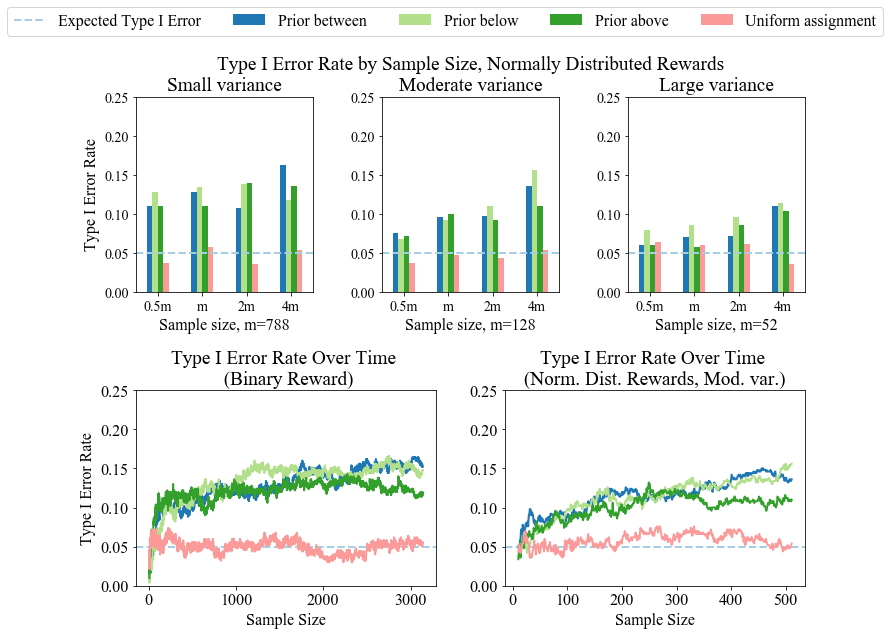

In [50]:
from matplotlib import gridspec
if use_pickle:
    import pickle
    binary_power = pd.read_pickle(date_prefix+'BinaryPowerSameArms.pkl')
    normal_power = pd.read_pickle(date_prefix_normal+'NormalPowerSameArms.pkl')
    normal_power_mid_var = pd.read_pickle(date_prefix_normal+'NormalPowerMidVarSameArms.pkl')
# Draw single graph for both binary and normal reward regarding type I error
figure = plt.figure(figsize = (12, 9))
gs = gridspec.GridSpec(2, 6)
gs.update(wspace = 1.25, hspace = .5)
setLegend = True

# Line graph for Type I Error per step for Binary Reward
# ax = figure.add_subplot(2, len(nsT) + 2, 1)
ax = plt.subplot(gs[1,0:3])

ax.axhline(0.05, color=colors[0], linestyle='dashed', linewidth=2)
i = 1
for p in binary_power:
    x = range(10, len(p)+10)
    ax.plot(x, p, lw=2, color=colors[i])
    i+=1
ax.set_xlabel('Sample Size')
ax.set_ylabel('Type I Error Rate')

# set visualization range to 0-1
ax.set_ylim(0.0, power_y_lim)
ax.tick_params(axis='both', which='major')
plt.title("Type I Error Rate Over Time \n (Binary Reward)")

# Subgraphs for Type I Error per step for Normal Reward
setLegend = True
ylabel = "Type I Error Rate"
# Bar graph for power at step m
for i in range(len(nsT)):
#     ax = figure.add_subplot(1, len(nsT) + 2, i + 2)
    ax = plt.subplot(gs[0,(2*i+0):(2*i+2)])

    avg_power_normal = normal_power[i]
    title_text = variance_label[i]+" variance"
    if i == len(nsT) // 2:
        title_text = "Type I Error Rate by Sample Size, Normally Distributed Rewards\n"+ title_text
    plot_power_bar(avg_power_normal, ["num_steps"], list(mean_names_lst), nsT[i], ax, setLegend, \
                   title_text, \
                   legend_anchor=(4.25, 1.5), ylabel=ylabel, hline_value=0.05, hline_label="Expected Type I Error")
    ax.tick_params(axis='both', which='major', labelsize=14)
    setLegend = False
    ylabel = ""
    
# Line graph for power per step for mid effect size
# ax = figure.add_subplot(1, len(nsT) + 2, len(nsT) + 2)
ax = plt.subplot(gs[1,3:6])

ax.axhline(0.05, color=colors[0], linestyle='dashed', linewidth=2)
i = 1
for p in normal_power_mid_var:
    x = range(10, len(p)+10)
    ax.plot(x, p, lw=2, color=colors[i])
    i+=1
ax.set_xlabel('Sample Size')
# set visualization range to 0-1
ax.set_ylim(0.0, power_y_lim)
ax.tick_params(axis='both', which='major')
plt.title("Type I Error Rate Over Time \n(Norm. Dist. Rewards, Mod. var.)")
starting_label_x = 0.1
label_y = 0
label_x_increment = 0.1625
# for i in range(5):
#     plt.gcf().text(starting_label_x+i*label_x_increment, label_y, \
#                    '(' + chr(ord('a')+i) + ')', fontsize=16)
# plt.subplots_adjust(top=0.75)
filename = outdir_prefix+"190617"+'TypeIErrorByStep.pdf'
print(filename)
figure.savefig(filename, bbox_inches='tight')
# plt.close(figure)

# Average Measured Effect Size (DONE)

In [23]:
def subplot_avg(df, ns, ax, setLegend, title, \
                ylabel="", hline_value=None, hline_label=None, setErrorBar=True, color=colors):
    means = df[list(mean_names_lst)]
    stds = df[list(std_names_lst)]
    stds.columns = list(mean_names_lst)
    
    if setErrorBar:
        means.plot.bar(ax=ax, yerr=stds, rot=0, color=color[1:])
    else:
        means.plot.bar(ax=ax, rot=0, color=color[1:])

    plt.xlabel("Step, m="+str(df.index[1]))
    ax.set_xticklabels(['0.5m', 'm', '2m', '4m'])
    
    legend = list(mean_names_lst)
    
    if hline_value!=None:
        ax.axhline(hline_value, color=color[0], linestyle='dashed', linewidth=2)
        legend.insert(0, hline_label)

    plt.title(title)
    
    if setLegend:
        ax.legend(legend, ncol=len(legend), bbox_to_anchor=(2.7, 1.35))
        ax.set_ylabel(ylabel)
    else:
        ax.legend_.remove()

### Binary Reward

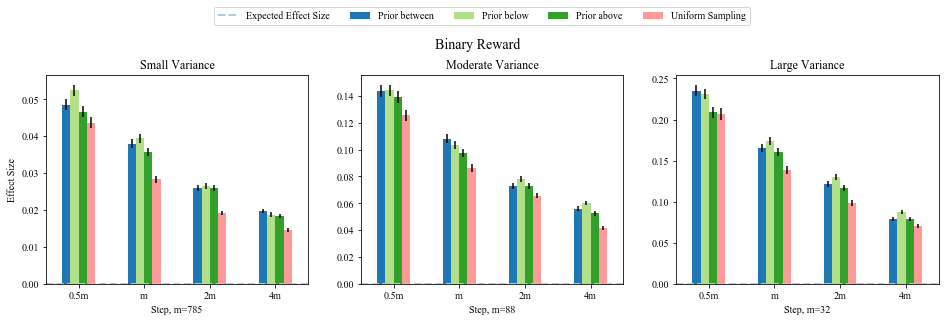

In [32]:
figure = plt.figure(figsize = (16, 4))
setLegend = True
stdError = True

# Plot subgraphs
for i in range(len(nsB)):
    ax = figure.add_subplot(1, len(nsB), i + 1)
    avg_act_es_binary = get_avg_col_per_num_steps_dfs(nsB[i], BINARY, "actual_es", stdError=stdError)
    subplot_avg(avg_act_es_binary, nsB[i], ax, setLegend, variance_label[i]+" Variance", \
                ylabel="Effect Size", hline_value=0.0, hline_label="Expected Effect Size", setErrorBar=True)
    setLegend = False
    
# Set super title for all subgraphs
figure.suptitle("Binary Reward",  fontsize=14)
plt.subplots_adjust(top=0.85)
if (stdError):
    outdir = outdir_prefix_std_error
else:
    outdir = outdir_prefix
figure.savefig(outdir+date_prefix+'AvgMeasuredESBinary.pdf', bbox_inches='tight')

### Normal Rewards

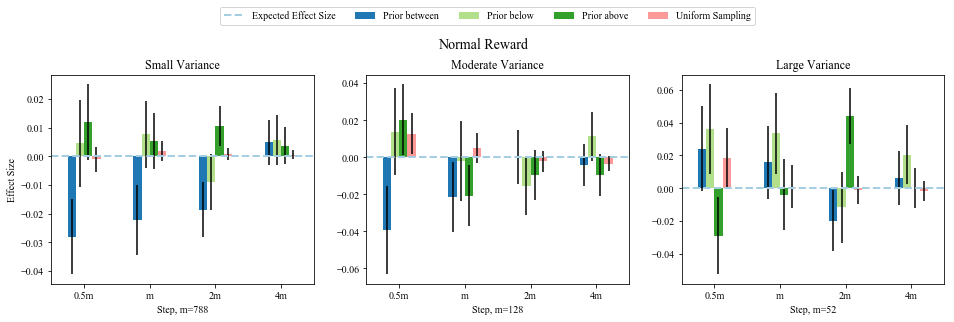

In [33]:
figure = plt.figure(figsize = (16, 4))
setLegend = True
stdError = True

# Plot subgraphs
for i in range(len(nsT)):
    ax = figure.add_subplot(1, len(nsT), i + 1)
    avg_act_es_normal = get_avg_col_per_num_steps_dfs(nsT[i], NORMAL, "actual_es", stdError=stdError)
    subplot_avg(avg_act_es_normal, nsT[i], ax, setLegend, variance_label[i]+" Variance", \
                ylabel="Effect Size", hline_value=0.0, hline_label="Expected Effect Size", setErrorBar=True)
    setLegend = False
    
# Set super title for all subgraphs
figure.suptitle("Normal Reward",  fontsize=14)
plt.subplots_adjust(top=0.85)
if (stdError):
    outdir = outdir_prefix_std_error
else:
    outdir = outdir_prefix
figure.savefig(outdir+date_prefix+'AvgMeasuredESNormal.pdf', bbox_inches='tight')

True
